# **Naive Bayes Сlassifier**

The Naive Bayes classifier is one of the most popular machine learning methods based on Bayes' theorem. It uses information about the distribution of classes in the training set to predict the class of a new object. One of the unique features of the Naive Bayes classifier is that it makes the assumption that all features are independent of each other. While this assumption is often incorrect, the Naive Bayes classifier still performs well in many real-world tasks.

The Naive Bayes classifier is often thought of as a good method for spam classification, but this is more of a myth than a reality. The Naive Bayes classifier is based on the assumption that all features are independent of each other, which is often not true in the case of spam. For example, the words "buy" and "discount" often appear together in spam emails, but the Naive Bayes classifier will consider them independent, which can lead to inaccurate results.
Therefore, while the Naive Bayes classifier can be effective in some cases, it is not the optimal choice for spam classification because the assumed independent distribution of features is often not true in this domain. At the same time, there are other machine learning methods such as logistic regression and support vector machines that are more commonly used for spam classification and typically give more accurate results.

### **Libraries**

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import Counter

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### **data**

In [2]:
url = 'https://raw.githubusercontent.com/tsebaka/ML-from-scratch/main/Classical%20ML/Probabilistic%20models/spam%20or%20ham%20data/train.csv'
data = pd.read_csv(url)

In [3]:
data

,id,text,label
0,4925,We can go 4 e normal pilates after our intro...,0.0
1,2349,That seems unnecessarily affectionate,0.0
2,1396,Thats cool! I am a gentleman and will treat yo...,0.0
3,475,Nice line said by a broken heart- Plz don't cu...,0.0
4,1473,Just sent you an email – to an address with in...,0.0
...,...,...,...
4175,3838,Early bird! Any purchases yet?,0.0
4176,423,Siva is in hostel aha:-.,0.0
4177,3824,Please protect yourself from e-threats. SIB ne...,0.0
4178,1836,* Will be september by then!,0.0


In [4]:
data = data.sample(frac=1).reset_index()
data = data.drop(columns={'index', 'id'})

In [5]:
text = data['text'].values
labels = data['label'].values

### **text preprocessing**

In [6]:
lemmatizer = WordNetLemmatizer()

In [7]:
def remove_punctuation(text):
    """
    Removes punctuation from a given string.
    Parameters:
    - text (str): The input string.

    Returns:
    - clean_text (str): The input string with punctuation removed.
    """
    return re.sub(r'[^\w\s]', '', text)

def transform(text, rm_punct=False):
    """
    Transforms a list of strings by lemmatizing and lowercasing each word,
     and optionally removing punctuation.
    Parameters:
    - text (list): A list of strings to transform.
    - rm_punct (bool): A flag indicating whether to remove punctuation from the input strings.

    Returns:
    - clean_text (list): A list of lists of transformed words, where each inner list represents a sentence 
    and each element of the inner list is a transformed word in the sentence.
    """
    clean_text = []

    if rm_punct:
        text = [remove_punctuation(sentence) for sentence in text]
    
    for sentence in text:
        words = word_tokenize(sentence)
        clean_text.append([lemmatizer.lemmatize(word.lower()) for word in words])
    
    return clean_text

### **NaiveBayesClassifier class**

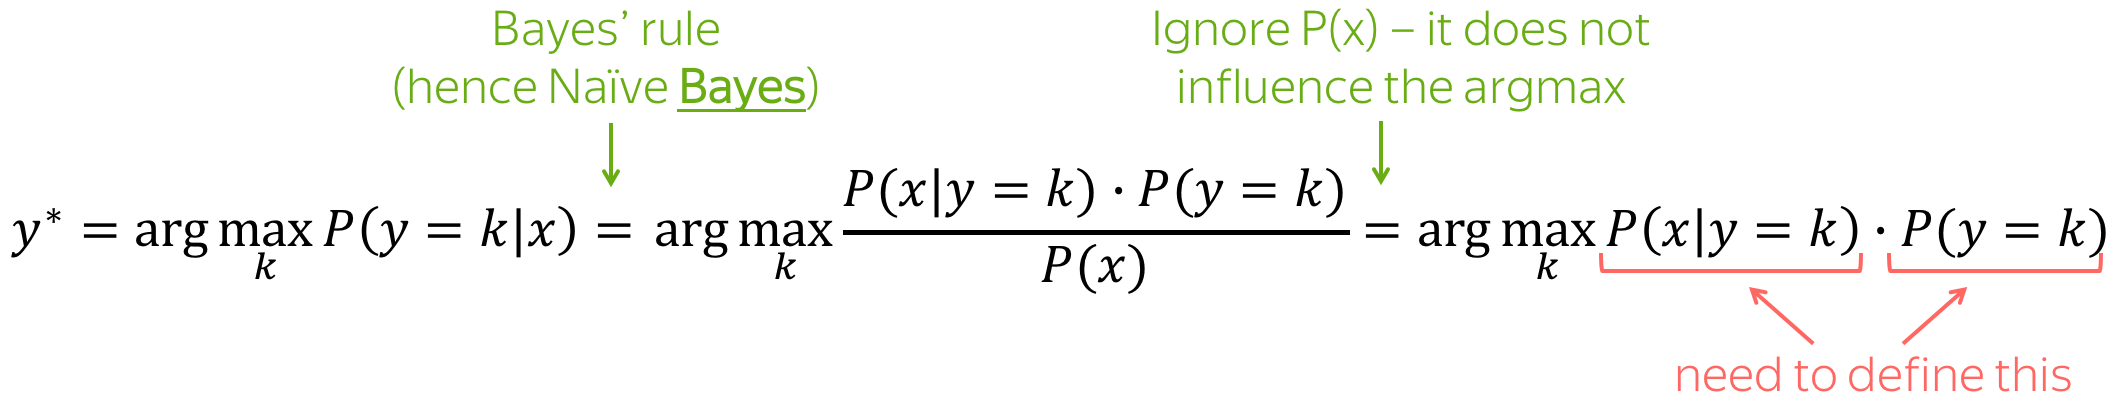

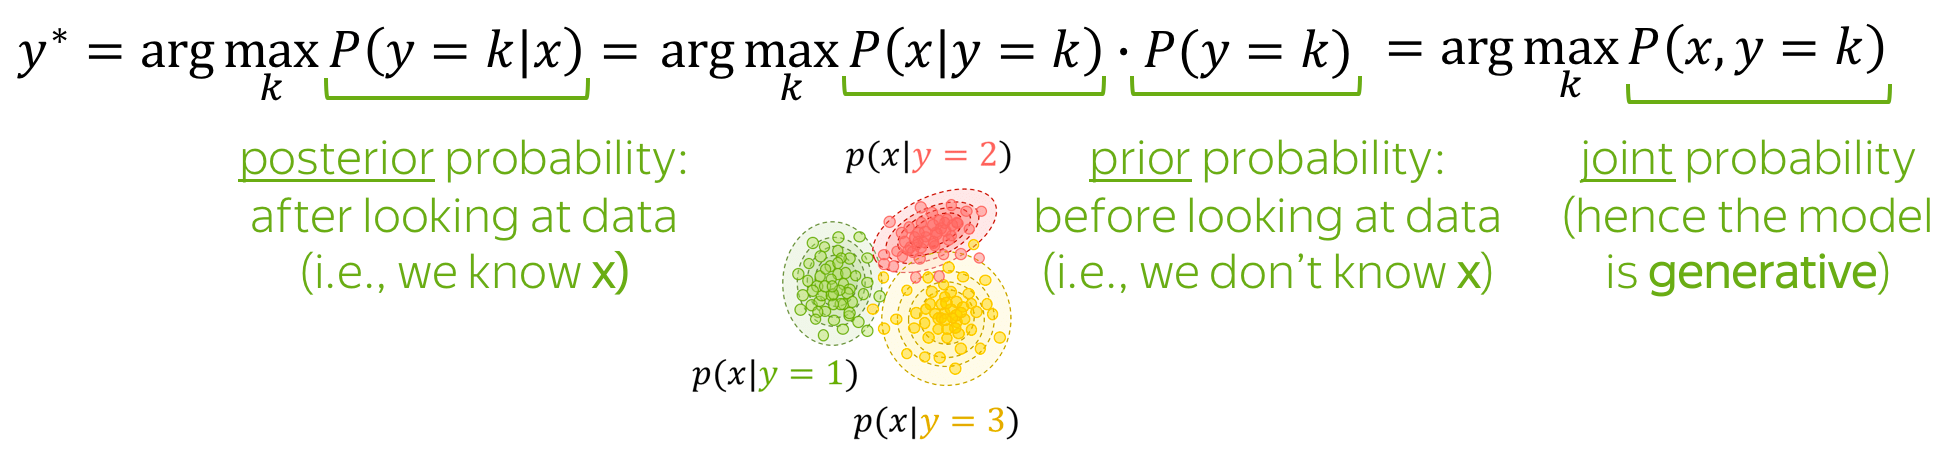

$$ P(y=k)=\frac{N(y=k)}{\sum\limits_{i}N(y=i)}, $$

$$ P(x| y=k)=P(x_1, \dots, x_n|y=k). $$

With these "naive" assumptions we get:

$$ P(x| y=k)=P(x_1, \dots, x_n|y=k)=\prod\limits_{t=1}^nP(x_t|y=k). $$

$$ P(x_i|y=k)=\frac{N(x_i, y=k)}{\sum\limits_{t=1}^{|V|}N(x_t, y=k)}, $$

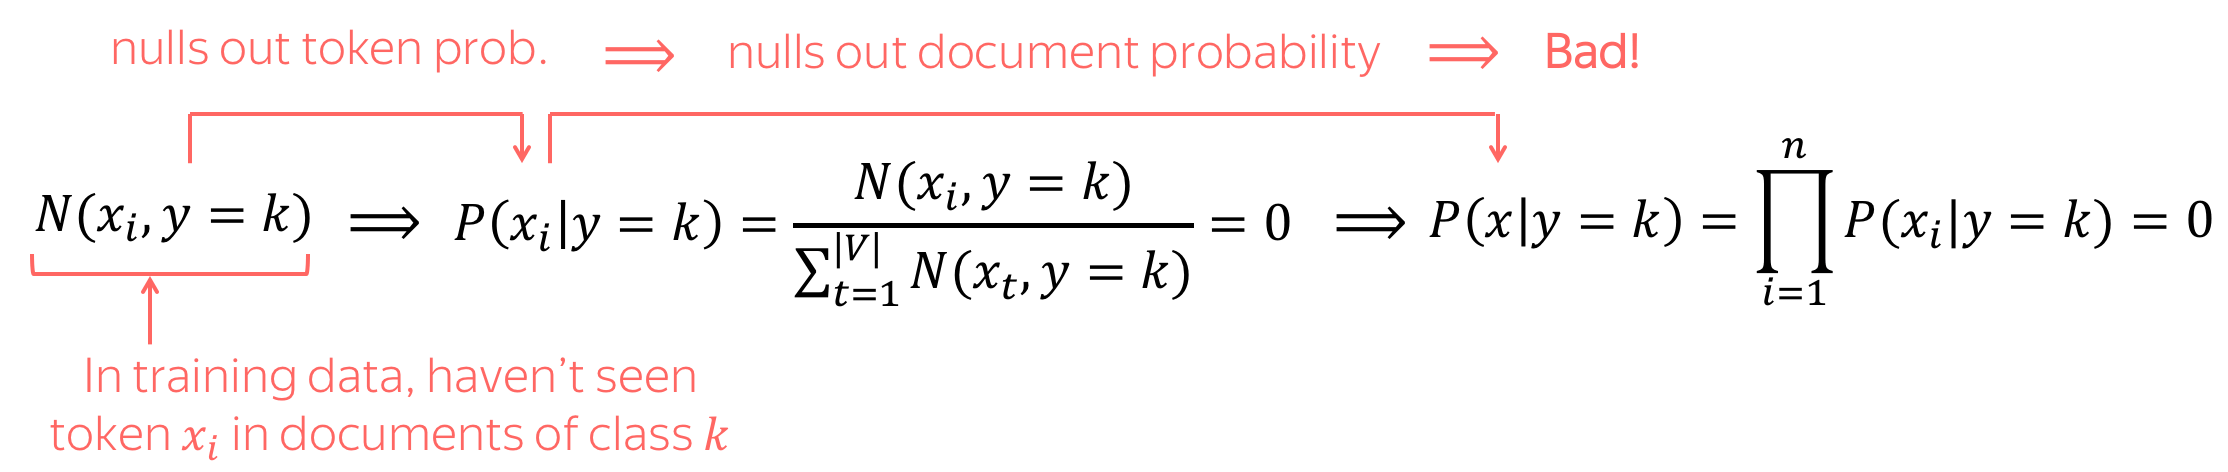

$$ 
P(x_i \mid y = k) = \frac{\textcolor{red}{\delta} + N(x_i,\ y = k)}{\sum_{t = 1}^{|V|}{(\color{red}{\delta} + N(x_t,\ y = k)})} = \frac{\color{red}{\delta} + N(x_i,\ y = k)}{\color{red}{\delta \cdot |V|} + \sum_{t = 1}^{|V|}{N(x_t,\ y = k)}}
$$

In [8]:
class NaiveBayesClassifier():
    """
    A Naive Bayes classifier for binary classification.
    """

    def __init__(self, var_smoothing=1e9):
        """
        Initializes the classifier with a specified smoothing parameter.
        Parameters:
        - var_smoothing aka delta (float): The smoothing parameter 
        to use when calculating probabilities. 
        A higher value results in less smoothing, and a lower value results in more smoothing.
        """
        self.var_smoothing = var_smoothing

    def prior_probability(self, label, labels):
        """
        Calculates the prior probability of a label occurring in the data.

        Parameters:
        - label (int): The label for which to calculate the prior probability.
        - labels (list): A list of labels in the data.

        Returns:
        - prior_prob (float): The prior probability of the label occurring in the data.
        """
        num_labels  = 0
        for target in labels:
            if target == label:
                num_labels += 1
        return num_labels  / len(labels)

    def distribution(self, label, word, text, labels):
        """
        Calculates the probability of a word occurring in a label.

        Parameters:
        - label (int): The label for which to calculate the probability of the word occurring.
        - word (str): The word for which to calculate the probability of occurring in the label.
        - text (list): A list of lists, where each inner list represents a sentence and each element of 
        the inner list is a word in the sentence.
        - labels (list): A list of labels corresponding to the sentences in `text`.

        Returns:
        - prob (float): The probability of the word occurring in the label.
        """
        num_all_words = 0
        num_words = 0

        for idx, sentence in enumerate(text):
            if labels[idx] == label:
                num_all_words += len(sentence)
                if word in sentence:
                    num_words += 1
        return (num_words + self.var_smoothing) / (self.var_smoothing * len(text) + num_all_words)

    def fit_predict(self, text, labels):
        """
        Fits the classifier to the data and predicts labels for a list of sentences.

        Parameters:
        - text (list): A list of lists, where each inner list represents a sentence and each element of 
        the inner list is a word in the sentence.
        - labels (list): A list of labels corresponding to the sentences in `text`.

        Returns:
        - y_pred (list): A list of predicted labels for the sentences in `text`.
        """
        y_pred = []

        for sentence in text:
            P_spam = self.prior_probability(1, labels)
            P_ham = self.prior_probability(0, labels)

            for word in sentence:
                """
                that assumption of independence which is often,
                for obvious reasons, 
                incorrect"
                """
                P_spam *= self.distribution(1, word, text, labels)
                P_ham *= self.distribution(0, word, text, labels)

            if P_ham < P_spam:
                y_pred.append(1)
            else:
                y_pred.append(0)

        return y_pred


### **testin**

In [9]:
NB = NaiveBayesClassifier(var_smoothing=0.2)

In [10]:
text = transform(text)

In [11]:
y_pred = NB.fit_predict(text, labels)

### **accuracy on train data**

In [12]:
accuracy_score(labels, y_pred)

0.9947368421052631

### **test data**

In [13]:
url = 'https://raw.githubusercontent.com/tsebaka/ML-from-scratch/main/Classical%20ML/Probabilistic%20models/spam%20or%20ham%20data/test.csv'
text = pd.read_csv(url)['text'].values

In [14]:
"""
I took this from my notebook for this task
(check notebook with sklearn implementation).
"""
url = 'https://raw.githubusercontent.com/tsebaka/ML-from-scratch/main/Classical%20ML/Probabilistic%20models/spam%20or%20ham%20data/preds_with_sklearn.csv'
y_true = pd.read_csv(url)['Predicted'].values

[Here](https://github.com/tsebaka/ML-from-scratch/blob/main/Classical%20ML/Probabilistic%20models/Naive%20Bayes%20Classifier.ipynb)

In [15]:
text = transform(text)

In [16]:
y_pred = NB.fit_predict(text, labels)

### **accuracy on test data**

In [17]:
accuracy_score(y_true, y_pred)

0.7912482065997131

### **resources**

[NLP Course | For You](https://lena-voita.github.io/nlp_course/text_classification.html)